In [1]:
import glob as glob
import os
import numpy as np
import mne 
import shutil
from mne.datasets import eegbci
from mne.datasets import sleep_physionet
import matplotlib.pyplot as plt
import pandas as pd
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
import torch
import numpy as np
import platform, os, re, multiprocessing
import pyedflib
import time  # Import the time module
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import platform, os, re, multiprocessing
import pandas as pd
import pyedflib
import mne
import matplotlib.pyplot as plt
import time  # Import the time module
import os
import mne
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import make_pipeline
import glob as glob
import numpy as np
import mne
import shutil
from mne.datasets import eegbci
from mne.datasets import sleep_physionet
import pandas as pd
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from datetime import timedelta
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
n = "/home/Duchuy220602/thesis/modify_file/brux_concatenated_raw.fif"

In [3]:
# Read the .fif file using mne.io.read_raw_fif
raw = mne.io.read_raw_fif(n, preload=True, verbose=0).crop(tmin=30, tmax = None )

Using matplotlib as 2D backend.


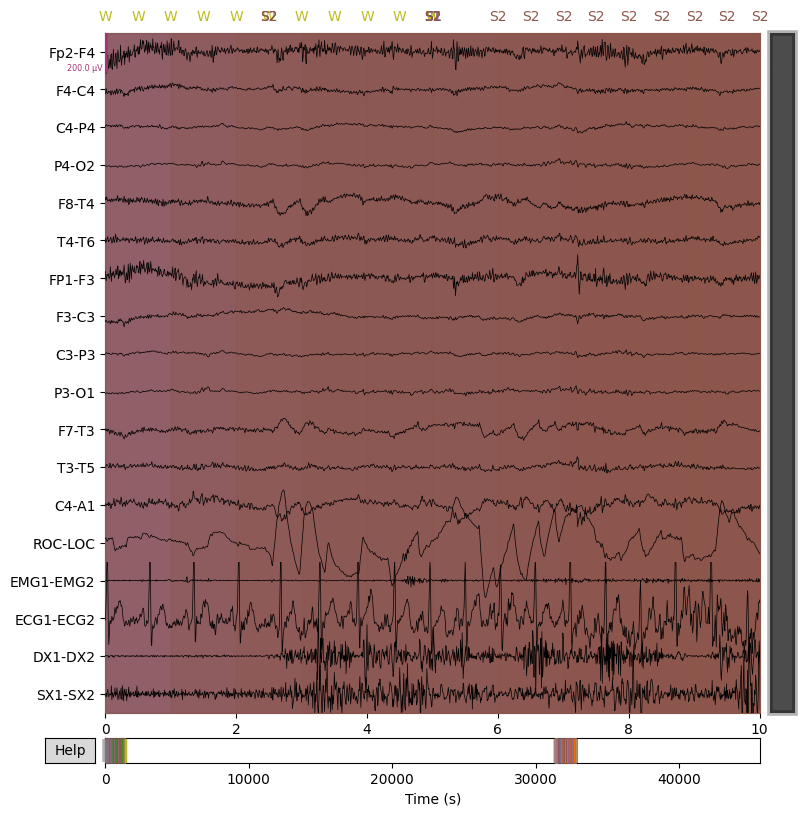

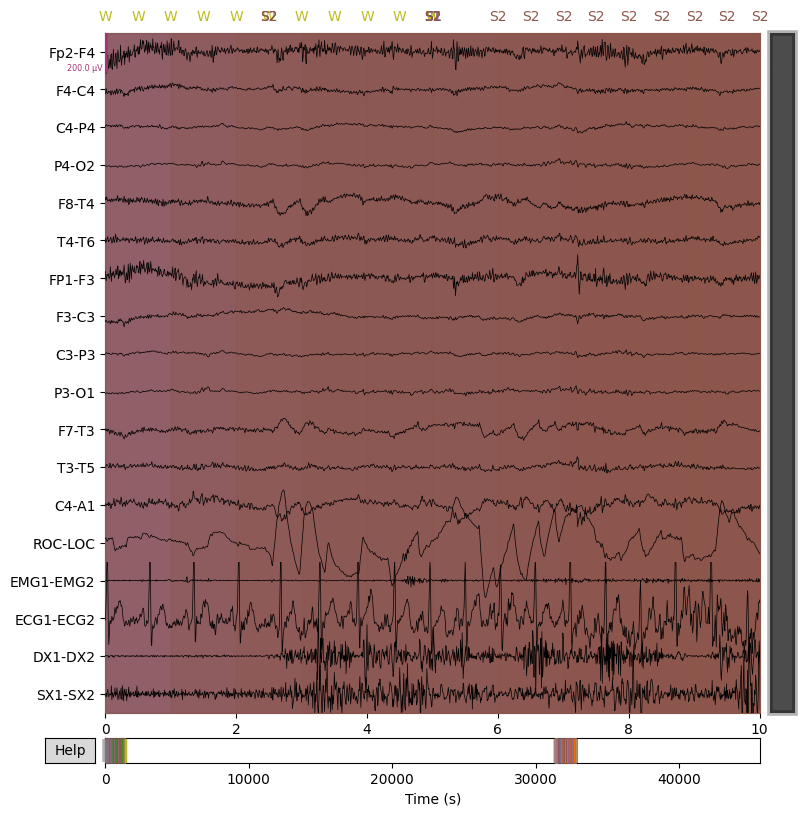

In [4]:
raw.plot(scalings=dict(eeg=100e-6))

In [5]:
# Define a dictionary mapping channel names to their types
channel_types = {
    'Fp2-F4': "eeg", 
    'F4-C4': "eeg", 
    'C4-P4': "eeg", 
    'P4-O2': "eeg",
    'C4-A1': "eeg"
}

# Define the default type for EEG channels
default_type = 'stim'

# You can set channel types for selected channels using a dictionary comprehension
channel_types_dict = {channel_name: channel_types.get(channel_name, default_type) for channel_name in raw.ch_names}
raw.set_channel_types(channel_types_dict)

<Raw | brux_concatenated_raw.fif, 18 x 5840896 (45632.0 s), ~802.1 MB, data loaded>

In [6]:
# Select only EEG channels
raw = raw.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [7]:
# Channel names in the current system
current_channel_names = [
    'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
    'C4-A1',
]

# Corresponding channel names in the 10-20 system
new_channel_names = [
    'F4', 'C4', 'P4', 'O2',
    'A1',
]


# Rename the channels to match the 10-20 system
channel_name_mapping = dict(zip(current_channel_names, new_channel_names))
raw.rename_channels(channel_name_mapping)

<Raw | brux_concatenated_raw.fif, 5 x 5840896 (45632.0 s), ~222.8 MB, data loaded>

In [8]:
# Set the standard 10-20 montage
raw.set_montage('standard_1020')

<Raw | brux_concatenated_raw.fif, 5 x 5840896 (45632.0 s), ~222.8 MB, data loaded>

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 14.9s.


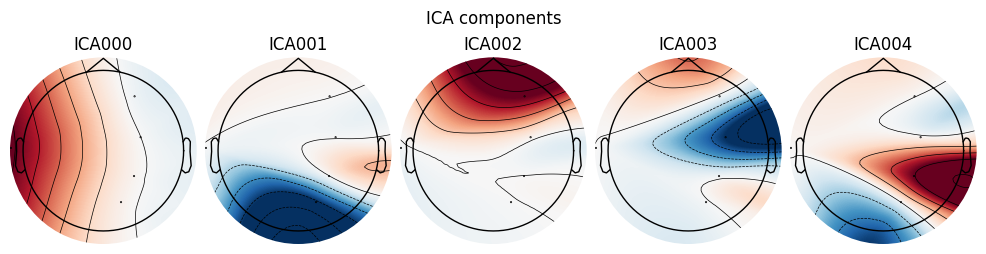

Creating RawArray with float64 data, n_channels=5, n_times=5840896
    Range : 3840 ... 5844735 =     30.000 ... 45661.992 secs
Ready.


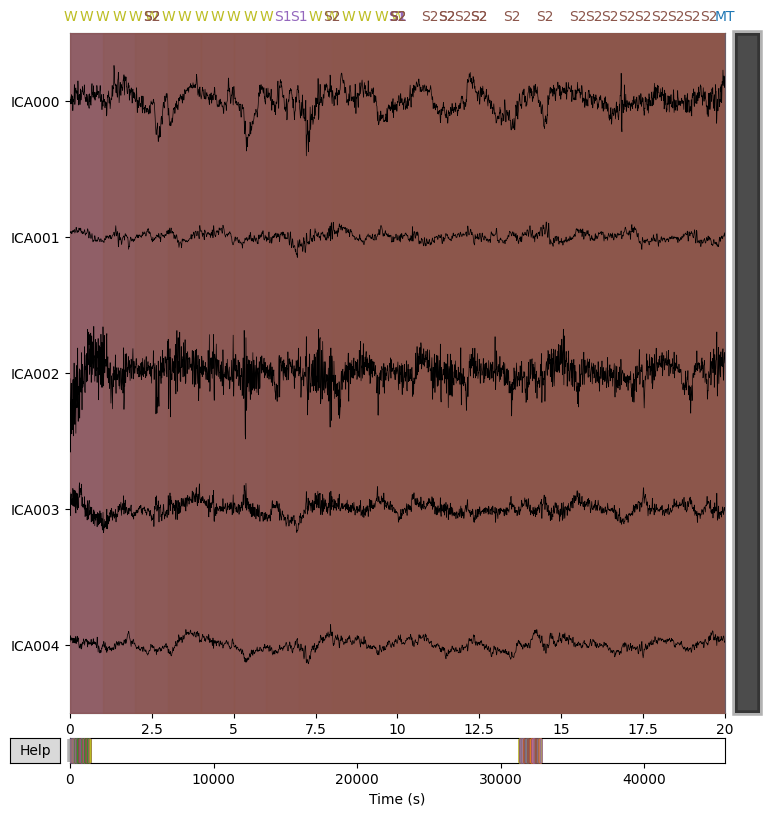

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 5 PCA components


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
ica = ICA(n_components=5, method="fastica", random_state=32, max_iter="auto")
ica.fit(raw)
ica.plot_components()
ica.plot_sources(raw)
raw = ica.apply(raw)

In [10]:
filter_length = '30s'

# Filter the data
raw.filter(0.5, 30, fir_design='firwin', filter_length=filter_length, method='fir', fir_window='hamming')

# Apply function to standardize the data
raw.apply_function(lambda x: (x - x.mean()) / x.std())

# Set EEG reference to 'average'
raw.set_eeg_reference('average')


# Extract the data and convert from V to uV
data = raw.get_data(units="uV")
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3841 samples (30.008 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Chan = ['F4', 'C4', 'P4', 'O2', 'A1']
Sampling frequency = 128.0 Hz
Data shape = (5, 5840896)


In [11]:
events, event_id = mne.events_from_annotations(raw)
print(len(events))

Used Annotations descriptions: ['MT', 'R', 'REM', 'S1', 'S2', 'S3', 'S4', 'W']
2927


Used Annotations descriptions: ['R', 'S1', 'S2', 'S3', 'S4', 'W']


/tmp/ipykernel_5537/1703340689.py:17: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(events_sleep, event_id=event_id,


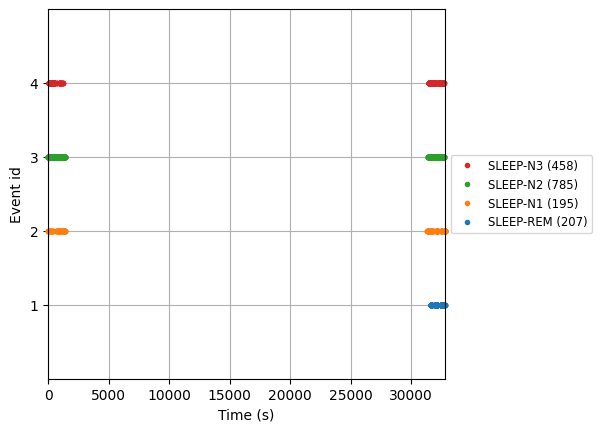

In [12]:
annotation_desc_2_event_id = {'R': 1, 'S1': 2, 'S2': 3, 'S3': 4, 'S4': 4, 'W': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw_clean data

events_sleep, _ = mne.events_from_annotations(
    raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id =  {
 'SLEEP-REM':1,
 'SLEEP-N1':2,
 'SLEEP-N2':3,
 'SLEEP-N3':4}

# plot events
fig = mne.viz.plot_events(events_sleep, event_id=event_id,
                          sfreq=raw.info['sfreq'],
                          first_samp=events_sleep[0, 0]);

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [13]:
mne.make_fixed_length_events(raw, duration = 30. , overlap = 3) 

array([[   3840,       0,       1],
       [   7296,       0,       1],
       [  10752,       0,       1],
       ...,
       [5830656,       0,       1],
       [5834112,       0,       1],
       [5837568,       0,       1]])

In [14]:
tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

# Create epochs from the raw data and events
epochs = mne.Epochs(raw=raw, events=events_sleep, event_id=event_id,
                     tmin=0., tmax=tmax, baseline=(0.5, 30.0), preload=True,
                     event_repeated='drop')

# 6. Apply bandpass filter
epochs.filter(0.5, 30, picks=['eeg'])

Not setting metadata
1645 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1645 events and 3840 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.9s
[Parallel(n_job

Number of events,1645
Events,SLEEP-N1: 195SLEEP-N2: 785SLEEP-N3: 458SLEEP-REM: 207
Time range,0.000 – 29.992 s
Baseline,0.500 – 30.000 s


In [15]:
event_id_inv = {v: k for k, v in event_id.items()}
event_id_inv

{1: 'SLEEP-REM', 2: 'SLEEP-N1', 3: 'SLEEP-N2', 4: 'SLEEP-N3'}

In [16]:
def bin_power_spectrum_1hz(psd, freqs):
    # Define a list to store the frequency bins from 1 to 35 Hz
    freqs_1hz_inc = list(range(1, 31))
    
    # Create an empty list to store the binned power values
    psds_binned_1hz = []
    
    # Initialize variables for the current bin frequency, sum, and size
    curr_bin_freq = 1  # Start at 1 Hz
    curr_bin_sum = 0
    curr_bin_size = 0
    
    # Loop through the frequency values
    for f in range(len(freqs)):
        # Check if the frequency is greater than or equal to the current bin frequency
        if int(freqs[f]) >= curr_bin_freq:
            # Calculate and append the average power for the current bin
            psds_binned_1hz.append(curr_bin_sum / curr_bin_size)
            
            # Reset the sum and size for the next bin
            curr_bin_sum = 0
            curr_bin_size = 0
            
            # Move to the next frequency bin
            curr_bin_freq += 1
        
        # Add the current power value to the sum and increase the size
        curr_bin_sum += psd[f]
        curr_bin_size += 1
    
    # Append the last frequency bin
    psds_binned_1hz.append(curr_bin_sum / curr_bin_size)
    
    # Return the binned frequencies and power values
    return freqs_1hz_inc, psds_binned_1hz

In [17]:
#Function to create frequency domain features
def create_frequency_domain_features(epoch_data, info, normalize_band_power_within_trials=False):
    
    # Compute the power spectral density and frequencies
    
    psds, freqs = mne.time_frequency.psd_array_multitaper(epoch_data, info['sfreq'], fmax=36, verbose=False)

    # Get the number of electrodes
    num_electrodes = len(psds)
    
    # Create a dictionary to store the features
    features_dict = {}
    
    # Loop through the electrodes
    for j in range(num_electrodes):
        # Bin the power spectrum into 1 Hz increments
        freqs_binned, psd_binned = bin_power_spectrum_1hz(psds[j], freqs)
        
        # Optionally normalize the power within trials
        if normalize_band_power_within_trials:
            psd_binned /= sum(psd_binned)
        
        # Loop through the binned frequencies
        for k in range(len(freqs_binned)):
            # Get the electrode name
            ch_name = info['ch_names'][j]
            
            # Create a string for the frequency bin
            freq_bin_str = str(freqs_binned[k]) + 'Hz'
            
            # Get the band power for the current bin
            band_power = psd_binned[k]
            
            # Create a feature name that includes the electrode and frequency bin
            feature_name = '{}_{}'.format(ch_name, freq_bin_str)
            
            # Add the feature to the dictionary
            features_dict[feature_name] = band_power
    
    # Return the dictionary of features
    return features_dict

In [18]:
event_id_inv = {v: k for k, v in event_id.items()}
event_id_inv

{1: 'SLEEP-REM', 2: 'SLEEP-N1', 3: 'SLEEP-N2', 4: 'SLEEP-N3'}

In [19]:
# 10. Split into X and y arrays
X = epochs.get_data(picks=['eeg'], tmin=.5)
y = [event_id_inv[epochs.events[i][-1]] for i in range(len(epochs))]

 # 11. Fit a LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 12. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

print("Number of training epochs:", len(X_train))
print("Number of testing epochs:", len(X_test))

Number of training epochs: 1151
Number of testing epochs: 494


In [20]:
# 13. Transform into frequency domain features
normalize_band_power_within_trials = True
X_s = pd.DataFrame([create_frequency_domain_features(
        epoch_data, epochs.info, normalize_band_power_within_trials) for epoch_data in X])

In [21]:
X_s_1 = X_s.filter(regex='C4|A1')

In [22]:
X_s_1

,C4_1Hz,C4_2Hz,C4_3Hz,C4_4Hz,C4_5Hz,C4_6Hz,C4_7Hz,C4_8Hz,C4_9Hz,C4_10Hz,...,A1_21Hz,A1_22Hz,A1_23Hz,A1_24Hz,A1_25Hz,A1_26Hz,A1_27Hz,A1_28Hz,A1_29Hz,A1_30Hz
0,0.441465,0.074027,0.032030,0.013755,0.011543,0.011584,0.009991,0.006777,0.006330,0.007558,...,0.011493,0.009975,0.006513,0.015773,0.023543,0.022705,0.005623,0.007434,0.011534,0.010747
1,0.624406,0.065901,0.020864,0.009264,0.007924,0.007466,0.006470,0.004813,0.003583,0.004596,...,0.008855,0.008519,0.005240,0.012552,0.019472,0.019098,0.004327,0.005901,0.010212,0.008421
2,0.728847,0.053135,0.014739,0.006653,0.005882,0.005392,0.004552,0.003351,0.002592,0.003213,...,0.008106,0.007929,0.004964,0.011201,0.017856,0.017349,0.003993,0.005365,0.009250,0.007799
3,0.771735,0.049033,0.012495,0.005403,0.004741,0.004766,0.003653,0.002765,0.002134,0.002659,...,0.007717,0.007834,0.004865,0.010645,0.017317,0.016652,0.003855,0.005274,0.008908,0.007633
4,0.784098,0.049169,0.011923,0.004979,0.004441,0.004495,0.003329,0.002703,0.002039,0.002518,...,0.007503,0.007901,0.004929,0.010848,0.017975,0.017222,0.003954,0.005346,0.009155,0.007304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,0.142445,0.181322,0.127874,0.103571,0.112980,0.098501,0.057400,0.035014,0.016966,0.018176,...,0.002232,0.002414,0.003165,0.002019,0.000834,0.002265,0.001822,0.000809,0.000888,0.000942
1641,0.105895,0.138460,0.114693,0.116071,0.150322,0.108441,0.064674,0.036596,0.024839,0.027070,...,0.002267,0.002374,0.003130,0.001779,0.000884,0.002154,0.001810,0.000711,0.000900,0.000934
1642,0.098368,0.133565,0.114285,0.128317,0.160070,0.109206,0.057336,0.031331,0.027981,0.032473,...,0.002352,0.002681,0.003125,0.001617,0.000845,0.002112,0.001786,0.000641,0.000956,0.000992
1643,0.076721,0.122018,0.119318,0.146289,0.172958,0.108894,0.052102,0.030630,0.029224,0.034500,...,0.002456,0.002680,0.003125,0.001661,0.000948,0.002080,0.001779,0.000613,0.001008,0.000964


In [23]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_s_1, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
clf = Pipeline([
    ('feature_selector', SelectKBest(score_func=f_classif, k=60)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=32))
])

In [25]:
scores = cross_val_multiscore(clf, X_train_1, y_train_1, cv=100, n_jobs=None)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   30.4s


Spatio-temporal: 91.2%


In [26]:
# Fit the pipeline to the training data
clf.fit(X_train_1, y_train_1)

# Make predictions on the test data
y_pred = clf.predict(X_test_1)

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test_1.ravel(), y_pred)

print("Accuracy score: {:.2f}%".format(accuracy * 100))

Accuracy score: 92.11%


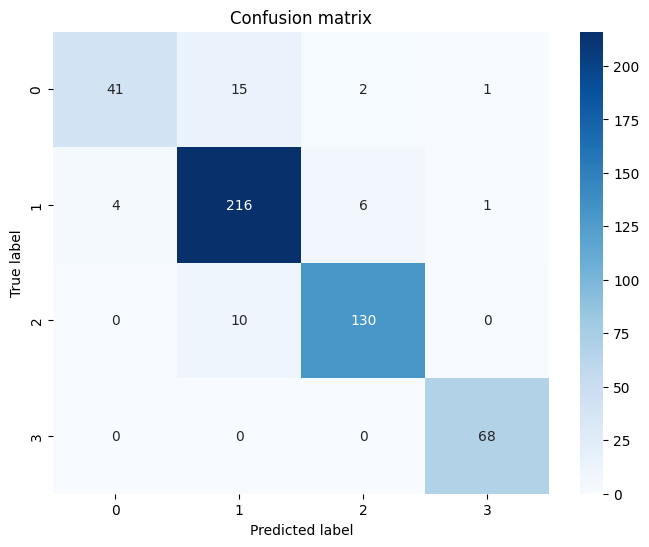

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test_1.ravel(), y_pred)

# Draw the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [28]:
print(confusion_matrix(y_test_1, y_pred))

# Get the confusion matrix
cm = confusion_matrix(y_test_1, y_pred)

print(classification_report(y_test_1, y_pred, target_names=event_id.keys()))

print("Unique labels in test set:", np.unique(y_test_1))

print("Unique predicted labels:", np.unique(y_pred))

[[ 41  15   2   1]
 [  4 216   6   1]
 [  0  10 130   0]
 [  0   0   0  68]]
              precision    recall  f1-score   support

   SLEEP-REM       0.91      0.69      0.79        59
    SLEEP-N1       0.90      0.95      0.92       227
    SLEEP-N2       0.94      0.93      0.94       140
    SLEEP-N3       0.97      1.00      0.99        68

    accuracy                           0.92       494
   macro avg       0.93      0.89      0.91       494
weighted avg       0.92      0.92      0.92       494

Unique labels in test set: [0 1 2 3]
Unique predicted labels: [0 1 2 3]


In [40]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(clf, X_train_1, y_train_1, return_train_score=True, cv = 100, return_estimator = True, verbose=False)
cv_results

{'fit_time': array([0.44916105, 0.43855119, 0.42553949, 0.4219532 , 0.42291045,
        0.42535663, 0.43006158, 0.43127775, 0.43020654, 0.42417288,
        0.42630935, 0.42300582, 0.42928028, 0.42609334, 0.42544723,
        0.42523456, 0.42009687, 0.41740584, 0.42420268, 0.42700171,
        0.42960906, 0.43493414, 0.4331727 , 0.43014431, 0.42314768,
        0.42111301, 0.42382479, 0.41718984, 0.42508507, 0.4193387 ,
        0.42176652, 0.42035151, 0.42292619, 0.42585301, 0.4213686 ,
        0.4185164 , 0.42078471, 0.42038512, 0.42133117, 0.42320991,
        0.41634893, 0.42178249, 0.42428207, 0.42403126, 0.42394662,
        0.42357135, 0.42412114, 0.42415142, 0.42672849, 0.42149401,
        0.42202759, 0.42431998, 0.42206764, 0.42437077, 0.42989945,
        0.42653275, 0.42242479, 0.41824484, 0.42316937, 0.42070627,
        0.41898584, 0.42017269, 0.422225  , 0.41838741, 0.41933942,
        0.42096925, 0.42858839, 0.42129683, 0.4229877 , 0.42370176,
        0.42314291, 0.420367  , 0.42

In [38]:
cv_results['train_score'].mean()

1.0

In [39]:
cv_results['test_score'].mean()

0.9175362318840579

In [32]:
y_hat = clf.predict(X_test_1)

performance = pd.DataFrame({"Actual" : np.squeeze(y_test_1),
                            "Predicted" : y_hat})
performance.head(20)

,Actual,Predicted
0,1,1
1,3,3
2,1,1
3,1,1
4,0,0
5,1,1
6,2,2
7,2,2
8,1,1
9,3,3


In [33]:
# import pandas as pd

# # Assuming X_s is your DataFrame
# selected_channels = ['C4', 'A1']
# selected_columns = []

# # Generate the column names for all channels and frequencies
# for channel in selected_channels:
#     selected_columns.extend(['{}_{}Hz'.format(channel, i) for i in range(1, 31)])

# # Create a new DataFrame with only the selected columns
# X_s_selected = X_s[selected_columns]

# # Specify the path where you want to save the CSV file
# csv_path = r'/home/Duchuy220602/thesis/file_feature/brux.csv'

# # Create the directory if it does not exist
# os.makedirs(os.path.dirname(csv_path), exist_ok=True)

# # Save the DataFrame to a CSV file
# X_s_selected.to_csv(csv_path, index=False)

# # Read the CSV file and print the first 5 rows
# df = pd.read_csv(csv_path)
# print(df.head())